# 1. Project Packages

In [16]:
from operator import truediv
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from torchsummary import summary
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as sio
import torch.nn as nn
import torchvision
import numpy as np
import spectral
import torch
import math
import wget
import time
import os

# 当前路径
pwd = os.getcwd()
# 当前路径的父路径
f_pwd = os.path.abspath(os.path.dirname(pwd) + os.path.sep + ".")
f_f_pwd = os.path.abspath(os.path.dirname(f_pwd) + os.path.sep + ".")
# print(f_f_pwd)
# print(f_pwd[-2]+f_pwd[-1])

# 2. Proposed Model

In [17]:
class CNN_3D_old(nn.Module):
    def __init__(self):
        super(CNN_3D_old, self).__init__()
        out_channels = [32, 64, 128]
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=1,
                      out_channels=out_channels[0],
                      kernel_size=(7, 7, 7),
                      stride=(1, 1, 1),
                      padding=(0, 1, 1)), nn.BatchNorm3d(out_channels[0]),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=out_channels[0],
                      out_channels=out_channels[1],
                      kernel_size=(5, 3, 3),
                      stride=(1, 1, 1),
                      padding=(0, 1, 1)),
            nn.BatchNorm3d(out_channels[1]),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Dropout3d(p=0.5),
        )
        self.layer3 = nn.Sequential(
            nn.Conv3d(in_channels=out_channels[1],
                      out_channels=out_channels[2],
                      kernel_size=(3, 1, 1),
                      stride=(1, 1, 1)),
            nn.BatchNorm3d(out_channels[2]),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.5),
        )
        self.classifier = nn.Linear(3456, class_num)

    def forward(self, x):
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer3 = torch.reshape(layer3, (layer3.shape[0], -1))
        out = self.classifier(layer3)
        return out

# 3. Data Preprocessing Modules

## 3.1 PCA for Data Dimensional Reducing

In [18]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

## 3.2 Forming Patches of hyperspectral images

In [19]:
# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros(
        (X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # 获得 y 中的标记样本数---10249
    count = 0
    for r in range(0, y.shape[0]):
        for c in range(0, y.shape[1]):
            if y[r, c] != 0:
                count = count + 1

    # split patches
    patchesData = np.zeros([count, windowSize, windowSize, X.shape[2]])
    patchesLabels = np.zeros(count)

    count = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            if y[r - margin, c - margin] != 0:
                patch = zeroPaddedX[r - margin:r + margin + 1,
                                    c - margin:c + margin + 1]
                patchesData[count, :, :, :] = patch
                patchesLabels[count] = y[r - margin, c - margin]
                count = count + 1

    return patchesData, patchesLabels

## 3.3 Splitting Dataset into trainSet & testingSet 

In [20]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

## 3.4 Data Loading

In [21]:
def loadData(name):
    data_path = "D:\VsCode WorkSpace\Hybrid2D&3D\Data"
    if name == 'IP':
        data = sio.loadmat(
            os.path.join(data_path, 'Indian-Pines\Indian_pines_corrected.mat')
        )['indian_pines_corrected']
        labels = sio.loadmat(
            os.path.join(
                data_path,
                'Indian-Pines\Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SV':
        data = sio.loadmat(
            os.path.join(data_path,
                         'Salinas\Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(
            data_path, 'Salinas\Salinas_gt.mat'))['salinas_gt']
    elif name == 'UP':
        data = sio.loadmat(
            os.path.join(data_path, 'Pavia-University\PaviaU.mat'))['paviaU']
        labels = sio.loadmat(
            os.path.join(data_path,
                         'Pavia-University\PaviaU_gt.mat'))['paviaU_gt']
    else:
        print("NO DATASET")
        exit()
    return data, labels

In [22]:
""" testing set """
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)

    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        # 返回文件数据的数目
        return self.len

""" training set """
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)

    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        # 返回文件数据的数目
        return self.len

## 3.5 Focalloss

In [23]:
def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)
    #loss = (1 - p) ** gamma * input_values
    loss = (1 - p)**gamma * input_values * 10
    return loss.mean()


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        return focal_loss(
            F.cross_entropy(input,
                            target,
                            reduction='none',
                            weight=self.weight), self.gamma)

# 4. Training Samples Initialization

In [24]:
name = f_pwd[-2] + f_pwd[-1]
f_name = f_f_pwd[-2] + f_f_pwd[-1]
if (name == "IP" or name == "SV"):
    class_num = 16
elif (name == "UP"):
    class_num = 9

X, y = loadData(name)
# 用于测试样本的比例
test_ratio = 0.85
# 每个像素周围提取 patch 的尺寸
patch_size = int(pwd[-2] + pwd[-1])
# 使用 PCA 降维，得到主成分的数量
pca_components = 15

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape)
print('before transpose: Xtest  shape: ', Xtest.shape)

Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape)
print('after transpose: Xtest  shape: ', Xtest.shape)

trainset = TrainDS()
testset = TestDS()
if name == "IP":
    train_loader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=53,  # 128,53
        shuffle=True,
        num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        dataset=testset,
        batch_size=53,  # 128,53
        shuffle=False,
        num_workers=0)
elif name == "SV" or name == "UP":
    train_loader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=128,  # 128,53
        shuffle=True,
        num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        dataset=testset,
        batch_size=128,  # 128,53
        shuffle=False,
        num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if name == "IP":
    one = torch.ones(53, dtype=torch.long).to(device)
elif name == "UP" or name == "SV":
    one = torch.ones(128, dtype=torch.long).to(device)

if test_ratio == 0.95:
    two = torch.ones(35, dtype=torch.long).to(device)
elif test_ratio == 0.90:
    two = torch.ones(17, dtype=torch.long).to(device)
elif test_ratio == 0.85:
    two = torch.ones(55, dtype=torch.long).to(device)

# 网络放到GPU上,一些metric的设定
net = CNN_3D_old().to(device)
criterion = FocalLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 15)

... ... create data cubes ... ...
Data cube X shape:  (10249, 19, 19, 15)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1537, 19, 19, 15)
Xtest  shape:  (8712, 19, 19, 15)
before transpose: Xtrain shape:  (1537, 19, 19, 15, 1)
before transpose: Xtest  shape:  (8712, 19, 19, 15, 1)
after transpose: Xtrain shape:  (1537, 1, 15, 19, 19)
after transpose: Xtest  shape:  (8712, 1, 15, 19, 19)


# 5.Training

In [25]:
# 训练开始时间
start_time = time.time()

net.train()
total_loss = 0
# proc_bar = tqdm(range(150))
for epoch in range(150):
    # proc_bar.set_description(f"正处于第{epoch}回合：")
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        try:
            labels = labels - one
        except:
            labels = labels - two
        #print(labels)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %
          (epoch + 1, total_loss / (epoch + 1), loss.item()))

# proc_bar.close()

[Epoch: 1]   [loss avg: 547.1448]   [current loss: 10.9392]
[Epoch: 2]   [loss avg: 406.4178]   [current loss: 8.7768]
[Epoch: 3]   [loss avg: 321.9571]   [current loss: 3.7698]
[Epoch: 4]   [loss avg: 266.6197]   [current loss: 2.7826]
[Epoch: 5]   [loss avg: 227.1366]   [current loss: 2.6156]
[Epoch: 6]   [loss avg: 197.4808]   [current loss: 1.1982]
[Epoch: 7]   [loss avg: 174.9351]   [current loss: 1.2652]
[Epoch: 8]   [loss avg: 156.8450]   [current loss: 0.6658]
[Epoch: 9]   [loss avg: 142.1325]   [current loss: 1.1072]
[Epoch: 10]   [loss avg: 130.0166]   [current loss: 0.9587]
[Epoch: 11]   [loss avg: 119.8026]   [current loss: 0.2830]
[Epoch: 12]   [loss avg: 111.0305]   [current loss: 0.5671]
[Epoch: 13]   [loss avg: 103.6396]   [current loss: 0.4083]
[Epoch: 14]   [loss avg: 97.0814]   [current loss: 0.4346]
[Epoch: 15]   [loss avg: 91.1329]   [current loss: 0.4235]
[Epoch: 16]   [loss avg: 85.8418]   [current loss: 0.1257]
[Epoch: 17]   [loss avg: 81.1314]   [current loss: 

## 5.1 Training time

In [26]:
end_time = time.time()
print(f"time cost:{(end_time-start_time)/60} min")
print('Finished Training')

time cost:1.953642197450002 min
Finished Training


# 6. Saving & Outputing the model params of proposed model

In [27]:
# 指定模型保存的地址
path = f"D:\\VsCode WorkSpace\\FEHN-FL\\Assets\\{f_name}\\{name}-Patch{patch_size}\\model.pth"
torch.save(net, path)
# 输出模型参数
summary(net, (1, pca_components, patch_size, patch_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 32, 9, 15, 15]          11,008
       BatchNorm3d-2        [-1, 32, 9, 15, 15]              64
              ReLU-3        [-1, 32, 9, 15, 15]               0
         MaxPool3d-4          [-1, 32, 9, 7, 7]               0
            Conv3d-5          [-1, 64, 5, 7, 7]          92,224
       BatchNorm3d-6          [-1, 64, 5, 7, 7]             128
              ReLU-7          [-1, 64, 5, 7, 7]               0
         MaxPool3d-8          [-1, 64, 5, 3, 3]               0
         Dropout3d-9          [-1, 64, 5, 3, 3]               0
           Conv3d-10         [-1, 128, 3, 3, 3]          24,704
      BatchNorm3d-11         [-1, 128, 3, 3, 3]             256
             ReLU-12         [-1, 128, 3, 3, 3]               0
        Dropout3d-13         [-1, 128, 3, 3, 3]               0
           Linear-14                   

# 7. Evaluating the proposed model

In [28]:
a = np.ones(Xtest.shape[0])  ##9225是Xtest.shape[0]
ytest = ytest - a

count = 0
# 模型测试
net.eval()
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test = outputs
        count = 1
    else:
        y_pred_test = np.concatenate((y_pred_test, outputs))

# 8. Generating the report of evaluation

In [29]:
# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)


def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports(test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred = outputs
            count = 1
        else:
            y_pred = np.concatenate((y_pred, outputs))

    if name == 'IP':
        target_names = [
            'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture',
            'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats',
            'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat',
            'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'
        ]
    elif name == 'SV':
        target_names = [
            'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow',
            'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery',
            'Grapes_untrained', 'Soil_vinyard_develop',
            'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk',
            'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk',
            'Lettuce_romaine_7wk', 'Vinyard_untrained',
            'Vinyard_vertical_trellis'
        ]
    elif name == 'UP':
        target_names = [
            'Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows'
        ]

    classification = classification_report(y_test,
                                           y_pred,
                                           target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)

    return classification, confusion, oa * 100, each_acc * 100, aa * 100, kappa * 100


# 将结果写在文件里
classification, confusion, oa, each_acc, aa, kappa = reports(
    test_loader, ytest, name)
classification = str(classification)
confusion = str(confusion)
file_name = f"D:\\VsCode WorkSpace\\FEHN-FL\\Assets\\{f_name}\\{name}-Patch{patch_size}\\classification_report({test_ratio}loss).txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{} training time (min)'.format((end_time - start_time) / 60))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        39
         1.0     0.9762    0.9456    0.9607      1214
         2.0     0.9888    0.9986    0.9937       706
         3.0     1.0000    0.9353    0.9666       201
         4.0     0.9901    0.9757    0.9828       411
         5.0     0.9951    0.9887    0.9919       621
         6.0     1.0000    1.0000    1.0000        24
         7.0     1.0000    1.0000    1.0000       406
         8.0     0.9444    1.0000    0.9714        17
         9.0     0.9892    0.9964    0.9928       826
        10.0     0.9633    0.9947    0.9788      2087
        11.0     1.0000    0.9266    0.9619       504
        12.0     1.0000    1.0000    1.0000       174
        13.0     1.0000    1.0000    1.0000      1075
        14.0     1.0000    0.9878    0.9939       328
        15.0     0.7980    1.0000    0.8876        79

    accuracy                         0.9826      8712
   macro avg     0.9778   

## 8.2 images of prediction report

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


d:\anaconda\envs\torch\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


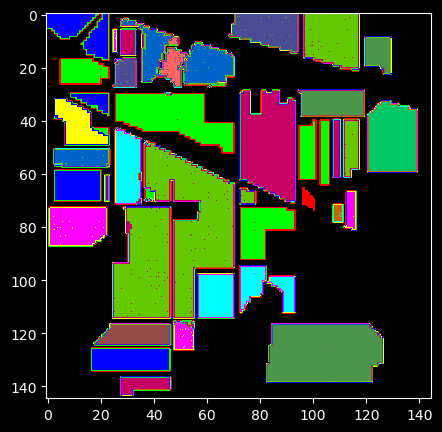

In [30]:
# 显示结果
# load the original image

my_color4IP = np.array([[255, 255, 255], [223, 214, 212], [191, 173, 169],
                        [159, 132, 126], [128, 92, 84], [160, 133, 102],
                        [192, 174, 119], [224, 215, 136], [253, 255, 153],
                        [189, 242, 140], [125, 229, 127], [61, 216, 114],
                        [0, 202, 106], [0, 170, 202], [10, 134, 236],
                        [31, 91, 193], [51, 51, 153]])

# my_color4IP_predict = np.array([[51, 204, 255], [223, 214, 212], [191, 173, 169],
#                         [159, 132, 126], [128, 92, 84], [160, 133, 102],
#                         [192, 174, 119], [224, 215, 136], [253, 255, 153],
#                         [189, 242, 140], [125, 229, 127], [61, 216, 114],
#                         [0, 202, 106], [0, 170, 202], [10, 134, 236],
#                         [31, 91, 193], [51, 51, 153]])

my_color4IP_predict = my_color4IP


X, y = loadData(name)

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents=pca_components)
X = padWithZeros(X, patch_size // 2)

# 逐像素预测类别
outputs = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        if int(y[i, j]) == 0:
            continue
        else:
            image_patch = X[i:i + patch_size, j:j + patch_size, :]
            image_patch = image_patch.reshape(1, image_patch.shape[0],
                                              image_patch.shape[1],
                                              image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(
                image_patch.transpose(0, 4, 3, 1, 2)).to(device)
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction + 1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

# oringal_image = spectral.imshow(classes=y, figsize=(5, 5))
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(5, 5))
# spectral.save_rgb("D:\VsCode WorkSpace\FEHN-FL\Pics\IP-15%-FEHN\(PU-3-3-0.85)FE-NET-原始.eps",
#                   y.astype(int),
#                   colors=my_color4IP)
spectral.save_rgb(r"D:\VsCode WorkSpace\FEHN-FL\Pics\IP-15%-FEHN\3d.eps",
                  outputs.astype(int),
                  colors=my_color4IP_predict)